In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path

# check if workding_dir is in local variables
if "workding_dir" not in locals():
    workding_dir = str(Path.cwd().parent)

os.chdir(workding_dir)
sys.path.append(workding_dir)
print("workding dir:", workding_dir)

workding dir: /Users/inflaton/code/engd/papers/rapget-translation


In [3]:
from dotenv import find_dotenv, load_dotenv

found_dotenv = find_dotenv(".env")

if len(found_dotenv) == 0:
    found_dotenv = find_dotenv(".env.example")
print(f"loading env vars from: {found_dotenv}")
load_dotenv(found_dotenv, override=True)

loading env vars from: /Users/inflaton/code/engd/papers/rapget-translation/.env


True

In [8]:
import os

model_name = os.getenv("MODEL_NAME")
adapter_name_or_path = os.getenv("ADAPTER_NAME_OR_PATH")
load_in_4bit = os.getenv("LOAD_IN_4BIT") == "true"
data_path = os.getenv("DATA_PATH")
results_path = "results/mac-results_few_shots.csv"  # os.getenv("RESULTS_PATH")
use_english_datasets = os.getenv("USE_ENGLISH_DATASETS") == "true"
max_new_tokens = int(os.getenv("MAX_NEW_TOKENS", 2048))

print(model_name, adapter_name_or_path, load_in_4bit, data_path, results_path, use_english_datasets, max_new_tokens)

01-ai/Yi-1.5-9B-Chat None False datasets/mac/mac.tsv results/mac-results_few_shots.csv False 300


In [9]:
%%time
os.environ["TOKENIZERS_PARALLELISM"] = "true"

!python --version
!pip show torch transformers

Python 3.11.9
Name: torch
Version: 2.4.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /Users/inflaton/anaconda3/envs/rapget/lib/python3.11/site-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: accelerate, peft, torchaudio, torchvision
---
Name: transformers
Version: 4.43.3
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /Users/inflaton/anaconda3/envs/rapget/lib/python3.11/site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenize

In [10]:
from llm_toolkit.llm_utils import *
from llm_toolkit.translation_utils import *

device = check_gpu()

MPS is available


In [11]:
import pandas as pd

df = pd.read_csv(results_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1133 entries, 0 to 1132
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   chinese                        1133 non-null   object
 1   english                        1133 non-null   object
 2   01-ai/Yi-1.5-9B-Chat/shots-00  1133 non-null   object
dtypes: object(3)
memory usage: 26.7+ KB


In [13]:
columns = df.columns[2:].to_list()
columns.sort()
columns = df.columns[:2].to_list() + columns
columns

['chinese', 'english', '01-ai/Yi-1.5-9B-Chat/shots-00']

In [14]:
df = df[columns]
metrics_df = get_metrics(df, max_output_tokens=max_new_tokens, variant="shots")
metrics_df

01-ai/Yi-1.5-9B-Chat/shots-00: {'meteor': 0.2624042529095214, 'bleu_scores': {'bleu': 0.052402107437040435, 'precisions': [0.22591505721240246, 0.07145192172979031, 0.03123880490076664, 0.014953453710264618], 'brevity_penalty': 1.0, 'length_ratio': 1.4560781715799933, 'translation_length': 43959, 'reference_length': 30190}, 'rouge_scores': {'rouge1': 0.2671501885495249, 'rouge2': 0.09630224265269001, 'rougeL': 0.22695449752648078, 'rougeLsum': 0.2285535947405311}, 'accuracy': 0.0, 'correct_ids': []}


model shots    meteor    bleu_1   rouge_l  ews_score  \
0  01-ai/Yi-1.5-9B-Chat    00  0.262404  0.052402  0.226954   0.008826   

   repetition_score  total_repetitions       rap  num_max_output_tokens  
0          1.593116           1.601942  0.246498                     18

In [15]:
models = metrics_df["model"].unique()
models

array(['01-ai/Yi-1.5-9B-Chat'], dtype=object)

In [16]:
# list of markers for plotting
markers = ["o", "x", "^", "s", "d", "P", "X", "*", "v", ">", "<", "p", "h", "H", "+", "|", "_"]
markers = {model: marker for model, marker in zip(models, markers)}

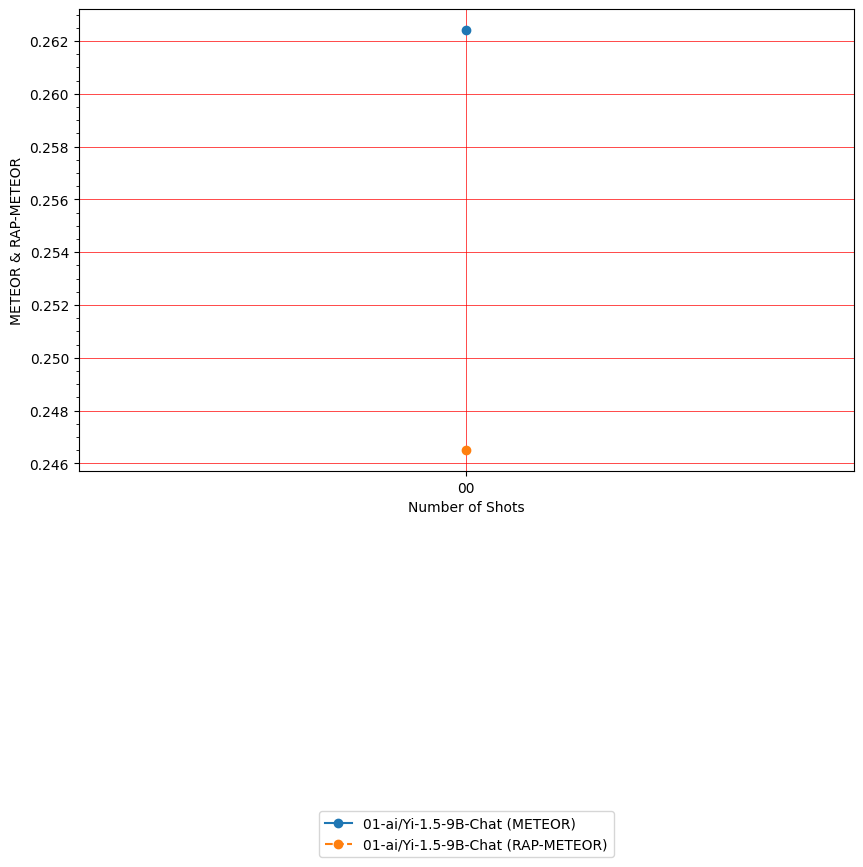

In [19]:
# plot meteor vs rpp
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
# set grid
ax.grid(True)
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(which="major", linestyle="-", linewidth="0.5", color="red")
# ax.grid(which="minor", linestyle=":", linewidth="0.5", color="black")

for model in models:
    model_df = metrics_df[metrics_df["model"] == model]
    ax.plot(
        model_df["shots"],
        model_df["meteor"],
        label=model + " (METEOR)",
        marker=markers[model],
    )
    ax.plot(
        model_df["shots"],
        model_df["rap"],
        label=model + " (RAP-METEOR)",
        linestyle="--",
        marker=markers[model],
    )

ax.set_xlabel("Number of Shots")
ax.set_ylabel("METEOR & RAP-METEOR")
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.85))
plt.show()

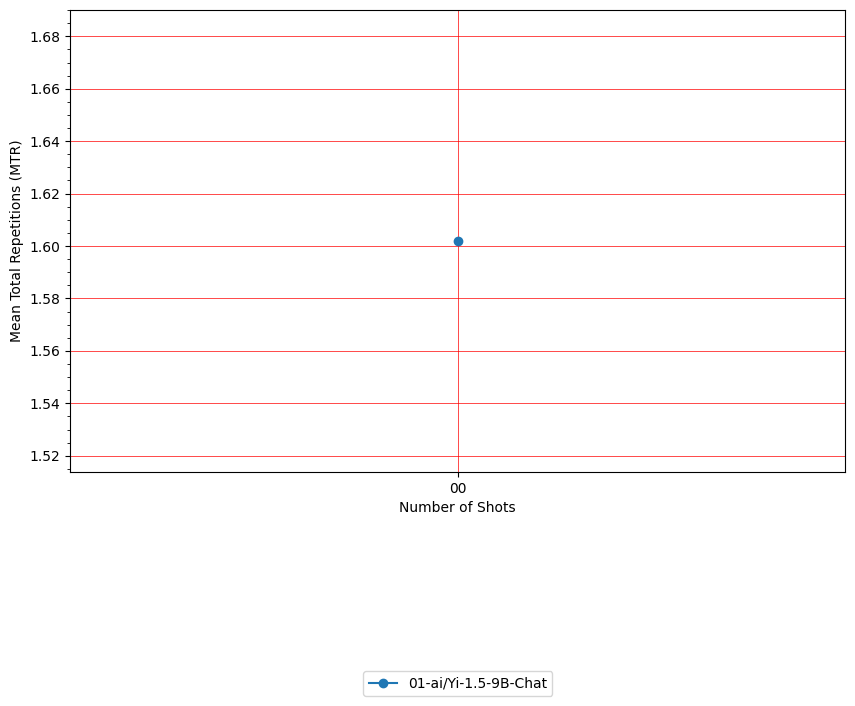

In [33]:
# plot mtr vs rpp
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
# set grid
ax.grid(True)
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(
    which="major", linestyle="-", linewidth="0.5", color="red"
)
# ax.grid(which="minor", linestyle=":", linewidth="0.5", color="black")

for model in models:
    model_df = metrics_df[metrics_df["model"] == model]
    ax.plot(
        model_df["shots"],
        model_df["total_repetitions"],
        label=model,
        marker=markers[model],
    )

# ax.set_ylim(0, 1)
ax.set_xlabel("Number of Shots")
ax.set_ylabel("Mean Total Repetitions (MTR)")
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.5))
plt.show()

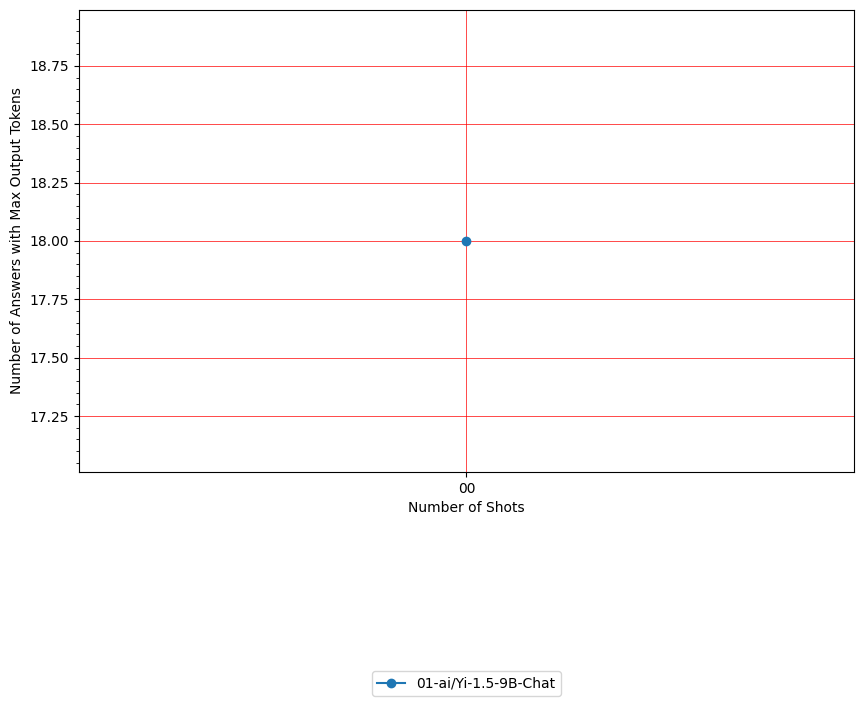

In [22]:
# plot mtr vs rpp
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
# set grid
ax.grid(True)
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(which="major", linestyle="-", linewidth="0.5", color="red")
# ax.grid(which="minor", linestyle=":", linewidth="0.5", color="black")

for model in models:
    model_df = metrics_df[metrics_df["model"] == model]
    ax.plot(model_df["shots"], model_df["num_max_output_tokens"], label=model, marker=markers[model])

# ax.set_ylim(0, 1)
ax.set_xlabel("Number of Shots")
ax.set_ylabel("Number of Answers with Max Output Tokens")
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.5))
plt.show()

In [23]:
def detect_repetitions_for_model_outputs(df, col, threshold=100):
    df[["ews_score", "repetition_score", "total_repetitions"]] = df[col].apply(
        detect_scores
    )
    return df.query(f"total_repetitions > {threshold}")

In [27]:
col = "01-ai/Yi-1.5-9B-Chat/shots-00"
rows = detect_repetitions_for_model_outputs(df, col, threshold=50)
rows

chinese  \
105  虽然我奶奶与他已经在高粱地里凤凰和谐，在那个半是痛苦半是幸福的庄严过程中，我奶奶虽然也怀上了...   
505                                     老子叫你不许哭，就不许哭！”   

                                               english  \
105  Even though by then he and Grandma had already...   
505                             'I forbid you to cry.'   

                         01-ai/Yi-1.5-9B-Chat/shots-00  \
105  Although my grandmother and him had already be...   
505  The task is asking you to:\n\n1. Understand th...   

     ground_truth_ews_score  ground_truth_repetition_score  \
105                       0                              0   
505                       0                              0   

     ground_truth_total_repetitions  ews_score  repetition_score  \
105                               0          0              1224   
505                               0          0               180   

     total_repetitions  ground_truth_tokens-01-ai/Yi-1.5-9B-Chat  \
105               1224                                       154   
505                180                                         8   

     output_tokens-01-ai/Yi-1.5-9B-Chat/shots-00  
105                                          309  
505                                          187

In [28]:
for i in range(len(rows)):
    row = rows.iloc[i]
    print(row["chinese"])
    print("=" * 80)
    print(row["english"])
    print("=" * 80)
    output = row[col]
    print(output)
    print("=" * 80)
    detect_repetitions(output, debug=True)

虽然我奶奶与他已经在高粱地里凤凰和谐，在那个半是痛苦半是幸福的庄严过程中，我奶奶虽然也怀上了我的功罪参半但毕竟是高密东北乡一代风流的父亲，但那时奶奶是单家的明媒正娶的媳妇，爷爷与她总归是桑间濮上之合，带着相当程度的随意性偶然性不稳定性，况且我父亲也没落土，所以，写到那时候的事，我还是称呼他余占鳌更为准确。
Even though by then he and Grandma had already done the phoenix dance in the sorghum field, and even though, in the solemn course of suffering and joy, she had conceived my father, whose life was a mixture of achievements and sin (in the final analysis, he gained distinction among his generation of citizens of Northeast Gaomi Township), she had nonetheless been legally married into the Shan family. So she and Granddad were adulterers, their relationship marked by measures of spontaneity, chance, and uncertainty. And since Father wasn't born while they were together, accuracy demands that I refer to Granddad as Yu Zhan'ao in writing about this period.
Although my grandmother and him had already been in the sorghum field with Phoenix in harmony, during that process that was both painful and happy, my grandmother although also got pregna

In [29]:
output_tokens = f"output_tokens-{col}"
df2 = df[df[output_tokens] >= max_new_tokens][
    ["chinese", "english", col, output_tokens]
]
print_row_details(df2, range(len(df2)))

--------------------------------------------------
chinese: 莺儿满心委屈，见姑娘说，不敢出声，只得放下钱来，口内嘟囔说：“一个做爷的，还赖我们这几个钱，连我也瞧不起!
--------------------------------------------------
english: Oriole smarted with the injustice of this, but her mistress had ordered it, so she had to pay up without arguing. She could not, however, forbear a few rebellious mutterings: 'Huh! One of the masters! Cheating a maid out of a few coppers! Even I should be ashamed!
--------------------------------------------------
01-ai/Yi-1.5-9B-Chat/shots-00: Part #1: You are a helpful assistant that translates Chinese to English.
Usage: "莺儿满心委屈， 见姑娘说，不敢出声， 只得放下钱来， 口内嘟囔说： “一个做爷的， 还赖我们这几个钱， 连我也瞧不起!" translates to "Ying'er was filled with grievances, but when the girl said something, she dare not speak up, so she had to put down the money, muttering, 'A man like you is still owed us this money, and you even look down on me!'" This meets the criteria because it is a translation from Chinese to English.

Part #2: If it is an incomple

In [30]:
len(df2)

18

In [31]:
df.describe()

ground_truth_ews_score  ground_truth_repetition_score  \
count                  1133.0                    1133.000000   
mean                      0.0                       0.312445   
std                       0.0                       7.193649   
min                       0.0                       0.000000   
25%                       0.0                       0.000000   
50%                       0.0                       0.000000   
75%                       0.0                       0.000000   
max                       0.0                     239.000000   

       ground_truth_total_repetitions    ews_score  repetition_score  \
count                     1133.000000  1133.000000       1133.000000   
mean                         0.312445     0.008826          1.614298   
std                          7.193649     0.209980         36.834513   
min                          0.000000     0.000000          0.000000   
25%                          0.000000     0.000000          0.000000   
50%                          0.000000     0.000000          0.000000   
75%                          0.000000     0.000000          0.000000   
max                        239.000000     5.000000       1224.000000   

       total_repetitions  ground_truth_tokens-01-ai/Yi-1.5-9B-Chat  \
count        1133.000000                               1133.000000   
mean            1.623124                                 33.044131   
std            36.834724                                 22.889653   
min             0.000000                                  1.000000   
25%             0.000000                                 17.000000   
50%             0.000000                                 28.000000   
75%             0.000000                                 42.000000   
max          1224.000000                                154.000000   

       output_tokens-01-ai/Yi-1.5-9B-Chat/shots-00  
count                                  1133.000000  
mean                                     59.693733  
std                                      65.755925  
min                                       4.000000  
25%                                      21.000000  
50%                                      37.000000  
75%                                      66.000000  
max                                     331.000000

In [32]:
metrics_df.to_csv(results_path.replace(".csv", "_metrics.csv"), index=False)